# Performance of the model notebook

This notebook generates figures and values to assess the final performance fo the 10 selected models.

## Library loading and additional function definition

In [1]:
# (c) Charles Le Losq 2021
# see embedded licence file

%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np
import seaborn as sns

# for plotting
import matplotlib.pyplot as plt 
import matplotlib, mpltern, corner
from mpltern.ternary.datasets import get_spiral
from matplotlib.patches import ArrowStyle, FancyArrowPatch
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# spearman corr coef
from scipy.stats import spearmanr

# mse
from sklearn.metrics import mean_squared_error

# imelt internals
import imelt

# other essentials
import torch, time, h5py

# we will work on CPU there
device = torch.device('cpu') #get_default_device()
print(device)


cpu


# Load dataset and models

In [2]:
path_data = "./data/NKAS_viscosity_reference.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = imelt.data_loader(path_data,path_raman,path_density,path_optical,device)

path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]

neuralmodel = imelt.bagging_models(path, name_list, ds, device)

In [3]:
ds.print_data()

################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 173
Number of unique compositions in training (viscosity): 113
Dataset separations are 0.65 in train, 0.14 in valid, 0.21 in test

Number of unique compositions (entropy): 44
Number of unique compositions in training (entropy): 30
Dataset separations are 0.68 in train, 0.16 in valid, 0.16 in test

Number of unique compositions (refractive index): 223
Number of unique compositions in training (refractive index): 160
Dataset separations are 0.72 in train, 0.14 in valid, 0.14 in test

Number of unique compositions (density): 205
Number of unique compositions in training (density): 139
Dataset separations are 0.68 in train, 0.16 in valid, 0.16 in test

Number of unique compositions (Raman): 58
Number of unique compositions in training (Raman): 48
Dataset separations are 0.83 in train, 0.17 in valid

This is for checking the consistency of the datase

# Root-mean-squared-errors calculations

Between all datasets and their predictions.

In [4]:
RMSE_ag_tot, RMSE_ag_low, RMSE_ag_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='ag', boundary=7)
RMSE_cg_tot, RMSE_cg_low, RMSE_cg_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='cg', boundary=7)
RMSE_tvf_tot, RMSE_tvf_low, RMSE_tvf_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='tvf', boundary=7)
RMSE_am_tot, RMSE_am_low, RMSE_am_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='am', boundary=7)
RMSE_myega_tot, RMSE_myega_low, RMSE_myega_high = imelt.RMSE_viscosity_bydomain(neuralmodel,ds,method='myega', boundary=7)

#
# Predictions for Raman spectra
#

# our real x axis, for resampling
x_raman_shift = np.arange(400.,1250.,1.0)

raman_train_predictions = neuralmodel.predict("raman_pred",ds.x_raman_train).mean(axis=2)
raman_valid_predictions = neuralmodel.predict("raman_pred",ds.x_raman_valid).mean(axis=2)

# Now we calculate on density and refractive index
ese_density_train = np.sqrt(mean_squared_error(ds.y_density_train.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_train).mean(axis=1)))
ese_density_valid = np.sqrt(mean_squared_error(ds.y_density_valid.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_valid).mean(axis=1)))
ese_density_test = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_test).mean(axis=1)))

ese_ri_train = np.sqrt(mean_squared_error(ds.y_ri_train.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_train,lbd=ds.lbd_ri_train).mean(axis=1)))
ese_ri_valid = np.sqrt(mean_squared_error(ds.y_ri_valid.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_valid,lbd=ds.lbd_ri_valid).mean(axis=1)))
ese_ri_test = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_test,lbd=ds.lbd_ri_test).mean(axis=1)))

print('RMSE density train after training {0:.3f}'.format(ese_density_train))
print('RMSE density valid after training {0:.2f}'.format(ese_density_valid))
print('RMSE density test after training {0:.2f}'.format(ese_density_test))
print('')

print('RMSE refractive train loss after training {0:.3f}'.format(ese_ri_train))
print('RMSE refractive valid loss after training {0:.3f}'.format(ese_ri_valid))
print('RMSE refractive test loss after training {0:.3f}'.format(ese_ri_test))
print('')


Using the equation from Adam-Gibbs:
    RMSE on the full range (0-15 log Pa s): train 0.3, valid 0.3, test 0.4
    RMSE on the -inf - 7.0 log Pa s range: train 0.2, valid 0.2, test 0.2
    RMSE on the 7.0 - +inf log Pa s range: train 0.3, valid 0.5, test 0.6

Using the equation from Free Volume:
    RMSE on the full range (0-15 log Pa s): train 0.3, valid 0.4, test 0.4
    RMSE on the -inf - 7.0 log Pa s range: train 0.2, valid 0.1, test 0.2
    RMSE on the 7.0 - +inf log Pa s range: train 0.3, valid 0.7, test 0.5

Using the equation from Vogel Fulcher Tamman:
    RMSE on the full range (0-15 log Pa s): train 0.3, valid 0.4, test 0.4
    RMSE on the -inf - 7.0 log Pa s range: train 0.3, valid 0.2, test 0.3
    RMSE on the 7.0 - +inf log Pa s range: train 0.3, valid 0.6, test 0.5

Using the equation from Avramov Milchev:
    RMSE on the full range (0-15 log Pa s): train 0.3, valid 0.4, test 0.4
    RMSE on the -inf - 7.0 log Pa s range: train 0.2, valid 0.2, test 0.2
    RMSE on the 7.0

# Comparison of viscosity predictions from all equations

This cell generates the code for the figure that compares measurements and predictions (from the 5 equations) for viscosity.

This is Supplementary Figure 2.

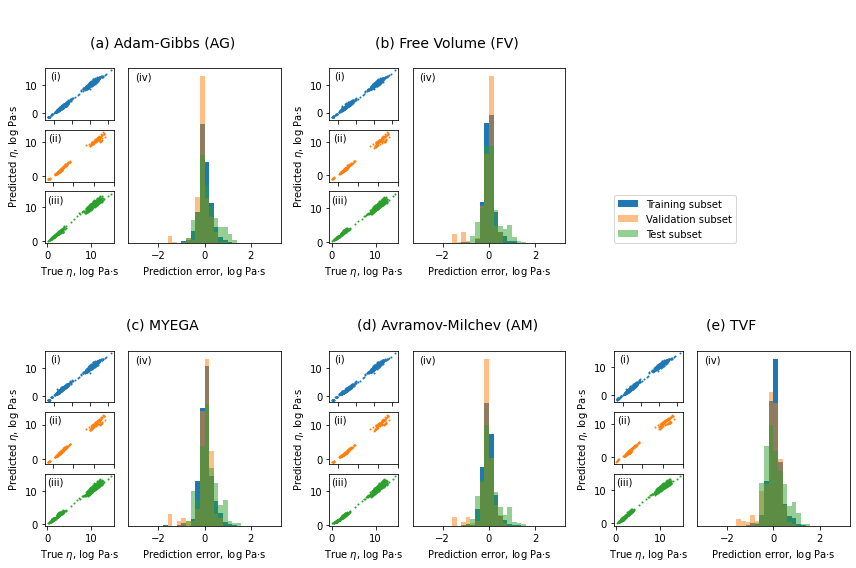

In [5]:
y_ag_train = neuralmodel.predict("ag",ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.predict("ag",ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.predict("ag",ds.x_visco_test,ds.T_visco_test)

y_tvf_train = neuralmodel.predict("tvf",ds.x_visco_train,ds.T_visco_train)
y_tvf_valid = neuralmodel.predict("tvf",ds.x_visco_valid,ds.T_visco_valid)
y_tvf_test = neuralmodel.predict("tvf",ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.predict("myega",ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.predict("myega",ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.predict("myega",ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.predict("am",ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.predict("am",ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.predict("am",ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.predict("cg",ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.predict("cg",ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.predict("cg",ds.x_visco_test,ds.T_visco_test)

fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(2,3)
sgs = gs[0,0].subgridspec(3,3)

def plot_panel(fig,gs,targets,results,title=''):
    c1 = 'C0'
    c2 = 'C1'
    c3 = 'C2'
    bins = np.linspace(-3,3,31)
    sgs = gs.subgridspec(4,3)
    ax = fig.add_subplot(sgs[1:4,1:3])
    n,b,h1 = ax.hist(results[0]-targets[0],bins,density=True,color=c1)
    n,b,h2 = ax.hist(results[1]-targets[1],bins,density=True,alpha=0.5,color=c2)
    n,b,h3 = ax.hist(results[2]-targets[2],bins,density=True,alpha=0.5,color=c3)
    ax.set_xlabel("Prediction error, log Pa$\cdot$s")
    ax.set_yticks([])
    ax.text(0.1,0.95,'(iv)',transform=ax.transAxes,va='center',ha='center')
    ax = fig.add_subplot(sgs[1,0])
    ax.scatter(targets[0],results[0],s=1,color=c1)
    ax.set_xticks([0,5,10,15])
    ax.set_xticklabels([])

    ax.text(0.15,0.85,'(i)',transform=ax.transAxes,va='center',ha='center')
    ax = fig.add_subplot(sgs[2,0])
    ax.scatter(targets[1],results[1],s=1,color=c2)
    ax.set_xticks([0,5,10,15])
    ax.set_xticklabels([])
    ax.text(0.15,0.85,'(ii)',transform=ax.transAxes,va='center',ha='center')
    ax.set_ylabel('Predicted $\eta$, log Pa$\cdot$s')
    ax = fig.add_subplot(sgs[3,0])
    ax.scatter(targets[2],results[2],s=1,color=c3)
    ax.text(0.15,0.85,'(iii)',transform=ax.transAxes,va='center',ha='center')
    ax.set_xlabel('True $\eta$, log Pa$\cdot$s')
    ax = fig.add_subplot(sgs[0,:])
    ax.text(0.5,0.3,title,va='center',ha='center',fontsize=14)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return sgs,h1,h2,h3
plot_panel(fig,gs[0,0],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_ag_train.mean(axis=1),
                        y_ag_valid.mean(axis=1),
                        y_ag_test.mean(axis=1)],"(a) Adam-Gibbs (AG)")

plot_panel(fig,gs[0,1],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_cg_train.mean(axis=1),
                        y_cg_valid.mean(axis=1),
                        y_cg_test.mean(axis=1)],"(b) Free Volume (FV)")

plot_panel(fig,gs[1,0],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_myega_train.mean(axis=1),
                        y_myega_valid.mean(axis=1),
                        y_myega_test.mean(axis=1)],"(c) MYEGA")

plot_panel(fig,gs[1,1],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_am_train.mean(axis=1),
                        y_am_valid.mean(axis=1),
                        y_am_test.mean(axis=1)],"(d) Avramov-Milchev (AM)")

sgs,h1,h2,h3 = plot_panel(fig,gs[1,2],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_tvf_train.mean(axis=1),
                        y_tvf_valid.mean(axis=1),
                        y_tvf_test.mean(axis=1)],"(e) TVF")
ax = fig.add_subplot(gs[0,2])
ax.legend([h1[0],h2[0],h3[0]],['Training subset','Validation subset','Test subset'],loc=(0.,0.))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

plt.savefig("./figures/SupplementaryFigure_2_compvisco.pdf")

# Raman spectra

The code below allows us to predict Raman spectra corresponding to those in the training and validation.

We generate a figure comparing predictions and observations.

Least-Absolute Deviations are also calculated, as well as the R_Raman parameters.

Median of the Relative Least Squared Error on Train Raman dataset is 21.32%
Median of the Relative Least Squared Error on Valid Raman dataset is 25.60%


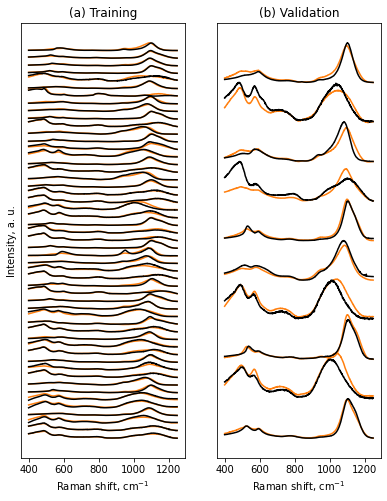

In [6]:
#
# Figure comparing Raman data to predictions
#

plt.figure(figsize=(6.44,8))

plt.subplot(1,2,1)
plt.title("(a) Training")
Raman_error_train = np.zeros(ds.x_raman_train.shape[0])
shift = 0.
for i in range(ds.x_raman_train.shape[0]):
    Raman_error_train[i] = np.mean(np.sqrt((raman_train_predictions[i,:]-ds.y_raman_train[i,:].detach().numpy())**2)/raman_train_predictions[i,:])
    plt.plot(x_raman_shift,raman_train_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    shift += 1.
plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")
plt.yticks([])

print("Median of the Relative Least Squared Error on Train Raman dataset is {0:.2f}%".format(np.median(Raman_error_train)*100))

plt.subplot(1,2,2)
plt.title("(b) Validation")
Raman_error_valid = np.zeros(ds.x_raman_valid.shape[0])
shift = 0.
for i in range(ds.x_raman_valid.shape[0]):
    Raman_error_valid[i] = np.mean(np.sqrt((raman_valid_predictions[i,:]-ds.y_raman_valid[i,:].detach().numpy())**2)/raman_valid_predictions[i,:])
    plt.plot(x_raman_shift,raman_valid_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    shift += 1.

plt.yticks([])
    
plt.xlabel("Raman shift, cm$^{-1}$")

print("Median of the Relative Least Squared Error on Valid Raman dataset is {0:.2f}%".format(np.median(Raman_error_valid)*100))

#
# Calculating the R_Raman
#

Rr_train = imelt.R_Raman(x_raman_shift, ds.y_raman_train.detach().numpy())
Rr_valid = imelt.R_Raman(x_raman_shift, ds.y_raman_valid.detach().numpy())

Rr_train_pred = imelt.R_Raman(x_raman_shift, raman_train_predictions)
Rr_valid_pred = imelt.R_Raman(x_raman_shift, raman_valid_predictions)

# Figure 6: Comparison between known values and predictions for other parameters (Tg, entropy...)

Tg test RMSE: 18.6
ScTg test RMSE: 0.8
density test RMSE: 0.014
Refractive index test RMSE: 0.0059
R_Raman training RMSE: 0.5
R_Raman validation RMSE: 0.3


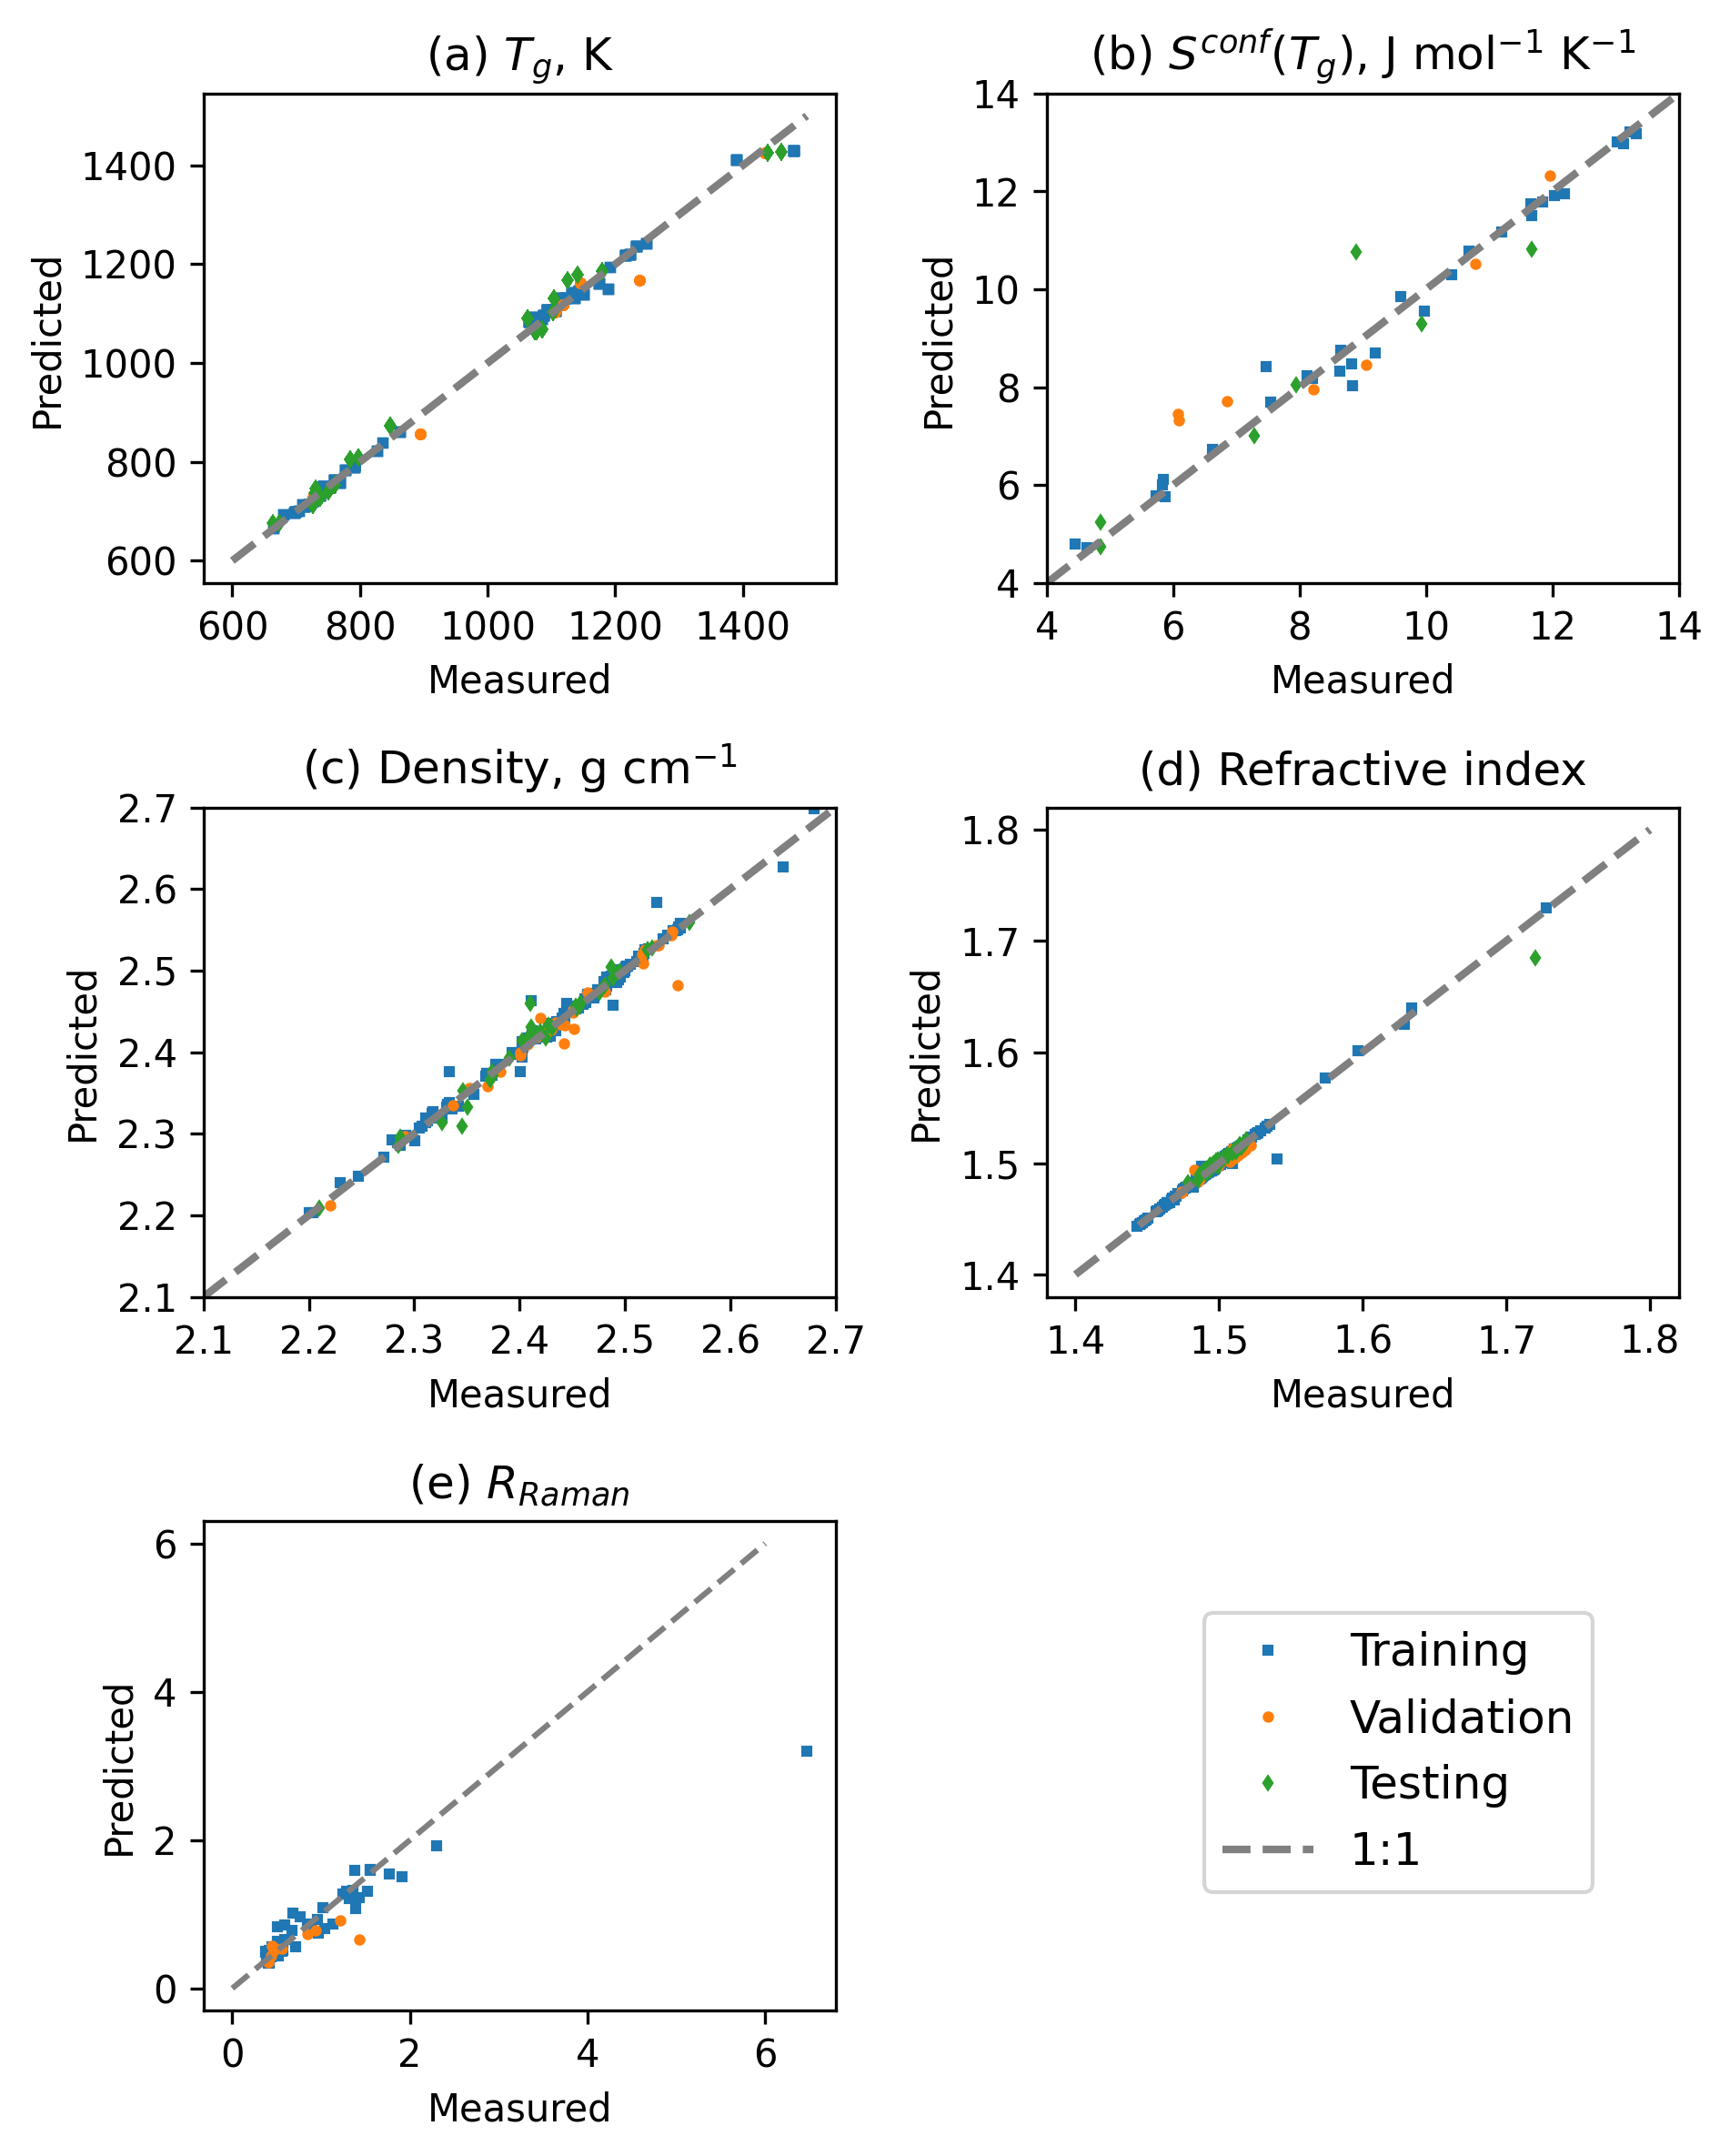

In [7]:
plt.figure(figsize=(6.44,8),dpi=300)

#
# Glass transition temperature
#
tx1 = plt.subplot(3,2,1)
tx1.plot(ds.y_tg_train.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_train).mean(axis=1),
         "s",linestyle="none",color="C0",markersize=2,label="Train",alpha=1)
tx1.plot(ds.y_tg_valid.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid",alpha=1)
tx1.plot(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test",alpha=1)
RMSE_test_Tg = np.sqrt(mean_squared_error(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1))) 
print("Tg test RMSE: {0:.1f}".format(RMSE_test_Tg))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(a) $T_g$, K")

plt.plot([600,1500],[600,1500],"--",color="grey",linewidth=2,label="1:1")

#
# Configurational entropy
#

tx2 = plt.subplot(3,2,2)
tx2.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train",alpha=1)
tx2.plot(ds.y_entro_valid.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid",alpha=1)
tx2.plot(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test",alpha=1)
RMSE_test_ScTg = np.sqrt(mean_squared_error(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1))) 
print("ScTg test RMSE: {0:.1f}".format(RMSE_test_ScTg))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(b) $S^{conf}(T_g)$, J mol$^{-1}$ K$^{-1}$")
plt.xlim(4,14)
plt.ylim(4,14)
plt.plot([4,14],[4,14],"--",color="grey",linewidth=2,label="1:1")

#
# Density
#

tx3=plt.subplot(3,2,3)
tx3.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train",alpha=1)
tx3.plot(ds.y_density_valid.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid",alpha=1)
tx3.plot(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test",alpha=1)
RMSE_test_d = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_test).mean(axis=1))) 
print("density test RMSE: {0:.3f}".format(RMSE_test_d))


plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(c) Density, g cm$^{-1}$")

plt.plot([2.1,2.7],[2.1,2.7],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(2.1,2.7)
plt.ylim(2.1,2.7)
plt.xticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])
plt.yticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])

#
# Refractive index
#

tx4 = plt.subplot(3,2,4)

tx4.plot(ds.y_ri_train.cpu().detach().numpy(),
         neuralmodel.predict("sellmeier",ds.x_ri_train, lbd=ds.lbd_ri_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Training",alpha=1.)
tx4.plot(ds.y_ri_valid.cpu().detach().numpy(),
         neuralmodel.predict("sellmeier",ds.x_ri_valid, lbd=ds.lbd_ri_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Validation",alpha=1.)
tx4.plot(ds.y_ri_test.cpu().detach().numpy(),
         neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Testing",alpha=1.)

RMSE_test_ri = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1))) 
print("Refractive index test RMSE: {0:.4f}".format(RMSE_test_ri))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(d) Refractive index")

plt.plot([1.4,1.8],[1.4,1.8],"--",color="grey",linewidth=2,label="1:1")
plt.xticks(np.arange(1.4,1.8,0.1))
plt.yticks(np.arange(1.4,1.8,0.1))

#
# Raman predictions : ratio of low to high frequency peaks
#

tx5 = plt.subplot(3,2,5)

plt.plot(Rr_train,Rr_train_pred,"s",color="C0",alpha=1.,markersize=2,label="Training")
plt.plot(Rr_valid,Rr_valid_pred,"o",color="C1",alpha=1.,markersize=2,label="Validation")
plt.plot([0,6],[0,6],"--",color="grey")
RMSE_train_Raman = np.sqrt(mean_squared_error(Rr_train_pred,Rr_train)) 
RMSE_valid_Raman = np.sqrt(mean_squared_error(Rr_valid_pred,Rr_valid)) 
print("R_Raman training RMSE: {0:.1f}".format(RMSE_train_Raman))
print("R_Raman validation RMSE: {0:.1f}".format(RMSE_valid_Raman))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(e) $R_{Raman}$")

plt.tight_layout()

tx4.legend(fontsize=12, bbox_to_anchor=(0.9,-0.6))

plt.savefig("./figures/SupplementaryFigure_3_compproperties.pdf")

# Figure 6: Fragility versus $C_p^{conf}/S^{conf}(T_g)$

A linear relationship should be visible according to the works of Webb (2008) or Russell and Giordano (2017)

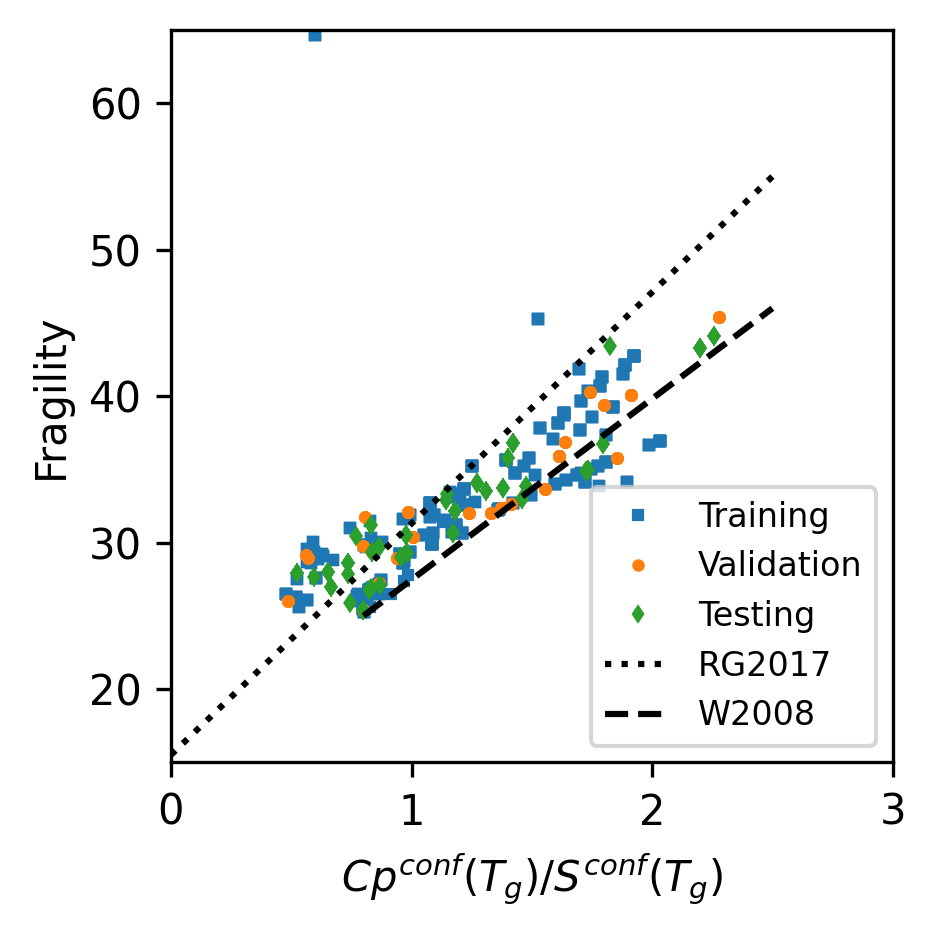

In [8]:
plt.figure(figsize=(3.22,3.22),dpi=300)
# Train

Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_train).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_train).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_train).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_train).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Training")

# Valid
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_valid).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_valid).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_valid).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_valid).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Validation")

# Test
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_test).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_test).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_test).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_test).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Testing")

plt.plot([0., 2.5],[15.51, 55],"k:",label="RG2017")
plt.plot([0.8, 2.5],[25., 46],"k--",label="W2008")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("Fragility")

plt.xlim(0,3)
plt.ylim(15,65)

plt.legend(fontsize = 8, loc=4)
plt.tight_layout()
plt.savefig("./figures/Figure6_mVSCpS.pdf")